<a href="https://colab.research.google.com/github/mihirahuja1/Spotify-Artist-Promotion/blob/master/Model_PCA_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook covers the following
1. Obtained PCA for our original dataset generated in Metainfo Notebook
2. Descriptive Analysis
3. Testing it on an 'Artist'

In [ ]:
### Setup

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import plotly.graph_objects as go

%config InlineBackend.figure_format='retina'
%matplotlib inline

In [ ]:
charts_with_audio_info = pd.read_csv('drive/My Drive/SpotifyDS/charts_with_audio_info.csv')

In [ ]:
charts_with_audio_info.head()

,Unnamed: 0,Unnamed: 0.1,Position,Track Name,Artist,Streams,URL,country_code,country_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,0,1,Conversations,Juice WRLD,3452709,https://open.spotify.com/track/2fZTS0VboxRpF0F...,us,United States,0.747,0.622,11.0,-5.825,1.0,0.0838,0.1760,0.0,0.151,0.570,159.930
1,1,1,2,Come & Go (with Marshmello),Juice WRLD,3220828,https://open.spotify.com/track/7y7w4tl4MaRC2UM...,us,United States,0.625,0.814,0.0,-5.181,1.0,0.0657,0.0172,0.0,0.158,0.535,144.991
2,2,2,3,Life's A Mess (feat. Halsey),Juice WRLD,3094307,https://open.spotify.com/track/4h5N4KyWZMtpeH9...,us,United States,0.630,0.446,1.0,-8.900,1.0,0.0351,0.3370,0.0,0.166,0.177,143.078
3,3,3,4,Hate The Other Side (with Marshmello feat. Pol...,Juice WRLD,2855162,https://open.spotify.com/track/66FgjA5ZQJJuypF...,us,United States,0.701,0.650,6.0,-6.313,1.0,0.1040,0.2910,0.0,0.112,0.647,90.003
4,4,4,5,Titanic,Juice WRLD,2826000,https://open.spotify.com/track/1QoG0Yqz1onMsdb...,us,United States,0.568,0.545,1.0,-6.668,0.0,0.0447,0.1680,0.0,0.112,0.234,174.144


In [ ]:
#Performing computation only on Audio Features
original_base_audio_information = charts_with_audio_info[['danceability',	'energy',	'key','loudness',	'mode','speechiness',	'acousticness',	'instrumentalness',	'liveness',	'valence',	'tempo']]


### Normalization

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(original_base_audio_information)
original_base_audio_information = pd.DataFrame(x_scaled)


In [ ]:
original_base_audio_information
original_base_audio_information.columns = original_base_audio_information.columns.astype(str)
original_base_audio_information= original_base_audio_information[['0','1','2','3','4','5','6','7','8','9','10']]
original_base_audio_information.columns = ['danceability', 'energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']

In [ ]:
song_info = charts_with_audio_info[['Position','Track Name','Artist','country_code','country_name']]

In [ ]:
song_with_normalized_meta_data = pd.concat([song_info,original_base_audio_information],axis=1)


In [ ]:
song_with_normalized_meta_data

,Position,Track Name,Artist,country_code,country_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1,Conversations,Juice WRLD,us,United States,0.712859,0.595604,1.000000,0.638559,1.0,0.070646,0.178634,0.000000,0.137877,0.565865,0.667574
1,2,Come & Go (with Marshmello),Juice WRLD,us,United States,0.560549,0.806593,0.000000,0.670297,1.0,0.049545,0.017407,0.000000,0.145140,0.528623,0.579529
2,3,Life's A Mess (feat. Halsey),Juice WRLD,us,United States,0.566792,0.402198,0.090909,0.487014,1.0,0.013873,0.342095,0.000000,0.153439,0.147691,0.568254
3,4,Hate The Other Side (with Marshmello feat. Pol...,Juice WRLD,us,United States,0.655431,0.626374,0.545455,0.614509,1.0,0.094194,0.295392,0.000000,0.097417,0.647797,0.255449
4,5,Titanic,Juice WRLD,us,United States,0.489388,0.510989,0.090909,0.597013,0.0,0.025064,0.170512,0.000000,0.097417,0.208342,0.751347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10977,196,In Your Eyes,The Weeknd,tw,Taiwan,0.612984,0.702198,0.636364,0.660933,0.0,0.013290,0.002837,0.000084,0.057579,0.722281,0.314491
10978,197,Sunday Best,Surfaces,tw,Taiwan,0.876404,0.489011,0.454545,0.588931,1.0,0.040336,0.185741,0.000000,0.055296,0.697808,0.385221
10979,198,你啊你啊 - 電視劇「用九柑仔店」插曲,Waa Wei,tw,Taiwan,0.510612,0.117582,0.818182,0.308905,1.0,0.015388,0.916747,0.000000,0.077601,0.149819,0.455002
10980,199,ME! (feat. Brendon Urie of Panic! At The Disco),Taylor Swift,tw,Taiwan,0.541823,0.824176,0.000000,0.723326,1.0,0.039520,0.033448,0.000000,0.103641,0.733986,0.798602


In [ ]:
song_with_normalized_meta_data.to_csv('drive/My Drive/SpotifyDS/song_with_normalized_meta_data.csv')

### Analysis on Meta data

In [ ]:
def barplot_for_meta_data(audio_feature):
    temp = song_with_normalized_meta_data.groupby(['country_name'])[audio_feature].mean().reset_index(name='Average').sort_values('Average')
    fig = px.bar(temp, y='Average', x='country_name',color='Average',title=audio_feature)
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    #fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
    print(fig.show())

## Q How each country does in terms of individual audio features?

In [ ]:
for feat in song_with_normalized_meta_data.columns[5:]:
    barplot_for_meta_data(feat)

None


None


None


None


None


None


None


None


None


None


None


In [ ]:
song_with_normalized_meta_data.columns[5:]

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

### Comparing Two Audio features 

In [ ]:
def scatterplot_for_meta_data(audio_feature_1,audio_feature_2):
    temp1 = song_with_normalized_meta_data.groupby(['country_name'])[[audio_feature_1,audio_feature_2]].mean().reset_index()
    temp1['sum_of_two_features'] = temp1[audio_feature_1] + temp1[audio_feature_2]
    
    fig = px.scatter(temp1, x=audio_feature_1, y=audio_feature_2, color='country_name',size='sum_of_two_features'
                  )
    #fig.show()
    print(fig.show())

In [ ]:
print("Choose from "+ str(song_with_normalized_meta_data.columns[5:]))
first_feature = input()
second_feature = input()
scatterplot_for_meta_data(first_feature,second_feature
)

Choose from Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')
danceability
loudness


None


### A 3-D plot to extending the previous plot to 3 audio features 

In [ ]:
def ThreeDscatterplot_for_meta_data(audio_feature_1,audio_feature_2,audio_feature_3):
    temp1 = song_with_normalized_meta_data.groupby(['country_name'])[[audio_feature_1,audio_feature_2,audio_feature_3]].mean().reset_index()
    temp1['sum_of_two_features'] = temp1[audio_feature_1] + temp1[audio_feature_2] + temp1[audio_feature_3]
    
    fig = px.scatter_3d(temp1, x=audio_feature_1, y=audio_feature_2,z=audio_feature_3 ,color='country_name',size='sum_of_two_features')
                  
    #fig.show()
    print(fig.show())

In [ ]:
print("Choose from "+ str(song_with_normalized_meta_data.columns[5:]))
first_feature = input()
second_feature = input()
third_feature = input()
ThreeDscatterplot_for_meta_data(first_feature,second_feature,third_feature
)

Choose from Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')
energy
key
loudness


None


## PCA

In [ ]:
##Applying PCA
original_base_audio_information
original_base_audio_information.fillna(0,inplace=True)

In [ ]:
pca = PCA(n_components=2)#To be run for original scalar
pct = pca.fit_transform(original_base_audio_information)


In [ ]:
pct

array([[-0.34295287, -0.56100407],
       [-0.51136913,  0.37065879],
       [-0.5028352 ,  0.43284977],
       ...,
       [-0.38523458, -0.15338166],
       [-0.51243048,  0.33962015],
       [-0.44645543,  0.15114721]])

In [ ]:
PCA_raw_data = pd.DataFrame(pct,columns=['pc1','pc2'])


In [ ]:
PCA_raw_data

,pc1,pc2
0,-0.342953,-0.561004
1,-0.511369,0.370659
2,-0.502835,0.432850
3,-0.410741,-0.126821
4,0.475031,0.559810
...,...,...
10977,0.585220,-0.098602
10978,-0.418072,-0.061043
10979,-0.385235,-0.153382
10980,-0.512430,0.339620


In [ ]:
PCA_with_country_names = pd.concat([PCA_raw_data,song_with_normalized_meta_data['country_name']],axis=1)


In [ ]:
temp1 = PCA_with_country_names.groupby(['country_name'])[['pc1','pc2']].mean().reset_index()
#temp1['sum_of_two_features'] = temp1['pc1'] + temp1['pc2']
    
fig = px.scatter(temp1, x='pc1', y='pc2', color='country_name')
    #fig.show()
print(fig.show())

None


## K-Means Clustering

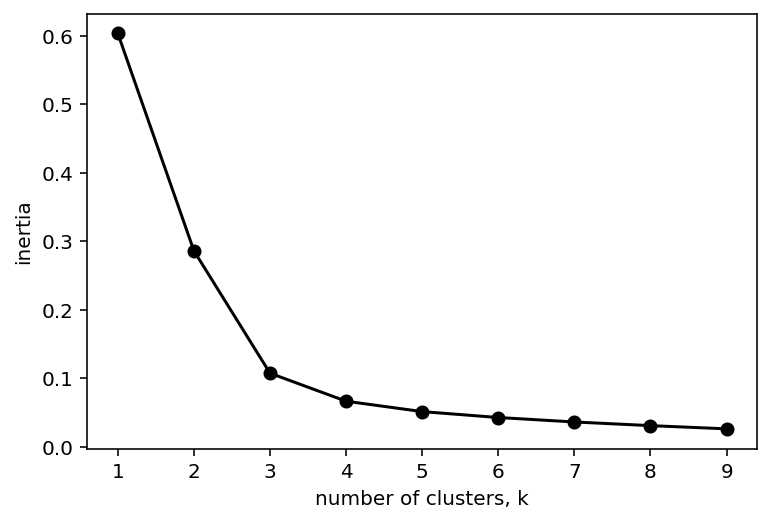

In [ ]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(temp1[['pc1','pc2']])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### With elbow method I could have chosen 3 but I felt that I could further divide my countries hence number of clusters chosen is 4

In [ ]:
kmeans = KMeans(n_clusters=4, init ='k-means++', max_iter=300, n_init=10,random_state=0 )

In [ ]:
y_kmeans = kmeans.fit_predict(temp1[['pc1','pc2']])
X = temp1[['pc1','pc2']]
y_kmeans

array([2, 2, 0, 0, 2, 2, 3, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 3, 3, 3, 3, 2,
       2, 1, 2, 2, 0, 1, 2, 3, 0, 1, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       1, 0, 3, 0, 2, 0, 2, 2, 0, 1, 1, 3, 2, 2], dtype=int32)

In [ ]:
X['Label'] = pd.DataFrame({'Label':y_kmeans})
X['Country'] = temp1['country_name']
X

,pc1,pc2,Label,Country
0,0.003141,-0.015711,2,Argentina
1,-0.017072,-0.004218,2,Australia
2,0.084352,0.021519,0,Austria
3,0.047227,0.013759,0,Belgium
4,-0.026166,-0.031574,2,Bolivia
5,-0.017765,-0.007013,2,Brazil
6,0.127508,-0.018027,3,Bulgaria
7,-0.001637,-0.027611,2,Canada
8,-0.019532,-0.007622,2,Chile
9,-0.055958,-0.032501,2,Colombia


In [ ]:
fig = px.scatter(X, x="pc1", y="pc2", color="Label",
                  hover_data=['Country'],color_continuous_scale=["red", "green", "blue","orange"])
fig.show()

## Where does an artist stand?

*The idea is to obtain audio features and observe where the artist falls in the two dimensional space and to which cluster it is closer to*

In [ ]:
#Get a new artist
cid= 'Your Client'
secret= 'Your Secret ID'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager
=
client_credentials_manager)

Choose any artist. I chose Led Zepplin(Because why not :)). Obtain it's artist ID

In [ ]:
lz_uri = 'spotify:artist:36QJpDe2go2KgaRleHCDTp'

results = sp.artist_top_tracks(lz_uri)


In [ ]:
list_of_songs = []
for i in range(0,len(results['tracks'])):
    list_of_songs.append(results['tracks'][i]['uri'])

In [ ]:
list_of_artist_tracks = pd.DataFrame(list_of_songs,columns=['uri'])

In [ ]:
cnt=0
artist_meta_info = pd.DataFrame()

def create_audio_features_df(song):
  global cnt
  global artist_meta_info
  try:
    d = sp.audio_features(song)[0]

    print(d)
    new_df = pd.DataFrame(d.values())
    new_df = new_df.transpose()
  except:
    new_df = pd.DataFrame(index=np.arange(1), columns=np.arange(18))
  if cnt == 0:
    artist_meta_info = new_df
  else:
    #print('here')
    x = pd.concat([artist_meta_info, new_df], ignore_index=True)
    artist_meta_info = x
  cnt+=1


In [ ]:
temp_df = list_of_artist_tracks['uri'].apply(lambda x : create_audio_features_df(x[14:]))

{'danceability': 0.338, 'energy': 0.34, 'key': 9, 'loudness': -12.049, 'mode': 0, 'speechiness': 0.0339, 'acousticness': 0.58, 'instrumentalness': 0.0032, 'liveness': 0.116, 'valence': 0.197, 'tempo': 82.433, 'type': 'audio_features', 'id': '5CQ30WqJwcep0pYcV4AMNc', 'uri': 'spotify:track:5CQ30WqJwcep0pYcV4AMNc', 'track_href': 'https://api.spotify.com/v1/tracks/5CQ30WqJwcep0pYcV4AMNc', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5CQ30WqJwcep0pYcV4AMNc', 'duration_ms': 482830, 'time_signature': 4}
{'danceability': 0.564, 'energy': 0.932, 'key': 11, 'loudness': -10.068, 'mode': 1, 'speechiness': 0.0554, 'acousticness': 0.013, 'instrumentalness': 0.169, 'liveness': 0.349, 'valence': 0.619, 'tempo': 112.937, 'type': 'audio_features', 'id': '78lgmZwycJ3nzsdgmPPGNx', 'uri': 'spotify:track:78lgmZwycJ3nzsdgmPPGNx', 'track_href': 'https://api.spotify.com/v1/tracks/78lgmZwycJ3nzsdgmPPGNx', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/78lgmZwycJ3nzsdgmPPGNx', 'duration

In [ ]:
artist_meta_info

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.338,0.34,9,-12.049,0,0.0339,0.58,0.0032,0.116,0.197,82.433,audio_features,5CQ30WqJwcep0pYcV4AMNc,spotify:track:5CQ30WqJwcep0pYcV4AMNc,https://api.spotify.com/v1/tracks/5CQ30WqJwcep...,https://api.spotify.com/v1/audio-analysis/5CQ3...,482830,4
1,0.564,0.932,11,-10.068,1,0.0554,0.013,0.169,0.349,0.619,112.937,audio_features,78lgmZwycJ3nzsdgmPPGNx,spotify:track:78lgmZwycJ3nzsdgmPPGNx,https://api.spotify.com/v1/tracks/78lgmZwycJ3n...,https://api.spotify.com/v1/audio-analysis/78lg...,146250,4
2,0.412,0.902,9,-11.6,1,0.405,0.0484,0.131,0.405,0.422,89.74,audio_features,0hCB0YR03f6AmQaHbwWDe8,spotify:track:0hCB0YR03f6AmQaHbwWDe8,https://api.spotify.com/v1/tracks/0hCB0YR03f6A...,https://api.spotify.com/v1/audio-analysis/0hCB...,333893,4
3,0.437,0.864,4,-7.842,0,0.0904,0.396,0.0314,0.242,0.749,81.394,audio_features,3qT4bUD1MaWpGrTwcvguhb,spotify:track:3qT4bUD1MaWpGrTwcvguhb,https://api.spotify.com/v1/tracks/3qT4bUD1MaWp...,https://api.spotify.com/v1/audio-analysis/3qT4...,295387,4
4,0.476,0.717,9,-9.192,1,0.0949,0.0382,7.61e-05,0.0818,0.753,93.584,audio_features,0QwZfbw26QeUoIy82Z2jYp,spotify:track:0QwZfbw26QeUoIy82Z2jYp,https://api.spotify.com/v1/tracks/0QwZfbw26QeU...,https://api.spotify.com/v1/audio-analysis/0QwZ...,166267,4
5,0.468,0.607,9,-11.367,1,0.0336,0.072,0.000852,0.225,0.886,98.429,audio_features,3MODES4TNtygekLl146Dxd,spotify:track:3MODES4TNtygekLl146Dxd,https://api.spotify.com/v1/tracks/3MODES4TNtyg...,https://api.spotify.com/v1/audio-analysis/3MOD...,263333,4
6,0.48,0.536,2,-11.166,1,0.0427,0.488,4.22e-05,0.155,0.581,80.617,audio_features,2nVHqZbOGkKWzlcy1aMbE7,spotify:track:2nVHqZbOGkKWzlcy1aMbE7,https://api.spotify.com/v1/tracks/2nVHqZbOGkKW...,https://api.spotify.com/v1/audio-analysis/2nVH...,508200,3
7,0.317,0.887,9,-7.292,1,0.0375,0.000582,0.00258,0.0891,0.871,169.613,audio_features,4PRGxHpCpF2yoOHYKQIEwD,spotify:track:4PRGxHpCpF2yoOHYKQIEwD,https://api.spotify.com/v1/tracks/4PRGxHpCpF2y...,https://api.spotify.com/v1/audio-analysis/4PRG...,220561,4
8,0.503,0.265,2,-15.913,1,0.0333,0.943,0.045,0.0867,0.522,78.044,audio_features,70gbuMqwNBE2Y5rkQJE9By,spotify:track:70gbuMqwNBE2Y5rkQJE9By,https://api.spotify.com/v1/tracks/70gbuMqwNBE2...,https://api.spotify.com/v1/audio-analysis/70gb...,212161,4
9,0.525,0.929,9,-8.56,0,0.0784,0.262,2.9e-05,0.0754,0.556,163.503,audio_features,4ItljeeAXtHsnsnnQojaO2,spotify:track:4ItljeeAXtHsnsnnQojaO2,https://api.spotify.com/v1/tracks/4ItljeeAXtHs...,https://api.spotify.com/v1/audio-analysis/4Itl...,262748,4


In [ ]:
artist_meta_info.columns = artist_meta_info.columns.astype(str)
artist_meta_info= artist_meta_info[['0','1','2','3','4','5','6','7','8','9','10']]
artist_meta_info.columns = ['danceability', 'energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']

### After obtaining audio feature info for top tracks of artist apply normaliztion and then PCA.
The important thing to note is that PCA should be applied on the previ

In [ ]:
artist_meta_info_normalized = pd.DataFrame(min_max_scaler.transform(artist_meta_info))

In [ ]:
##PCA

In [ ]:
artist_meta_info_PCA = pd.DataFrame(pca.transform(artist_meta_info_normalized),columns=['pc1','pc2'])

In [ ]:
artist_meta_info_PCA

,pc1,pc2
0,0.592498,-0.020510
1,-0.339538,-0.595269
2,-0.365686,-0.358793
3,0.537624,0.211007
4,-0.372243,-0.402638
5,-0.365635,-0.402113
6,-0.477820,0.306279
7,-0.387781,-0.430921
8,-0.475959,0.411072
9,0.599613,-0.214318


In [ ]:
### Taking Average

In [ ]:
artist_meta_info_PCA['Name']='Led_Zepplin'

In [ ]:
final_position_of_artist = artist_meta_info_PCA.groupby('Name')['pc1','pc2'].mean().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
final_position_of_artist

,Name,pc1,pc2
0,Led_Zepplin,-0.105493,-0.14962


In [ ]:
country_data = X

In [ ]:
kmeans.predict(final_position_of_artist[['pc1','pc2']])

array([2], dtype=int32)

In [158]:


fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=X["pc1"], y=X["pc2"],marker_color=X["Label"],
                    mode='markers',text=X['Country']
                    ))
fig.add_trace(go.Scatter(x=final_position_of_artist["pc1"], y=final_position_of_artist["pc2"],marker_color='green',
                    mode='markers'
                    ))


The green dot below is the 2D representation for current artist

In [ ]:
###